In [1]:
import sys
sys.path.append("./source")

# libraries for this project
from lmmNet import *
import harmonic
import train_onestep
import predict_onestep
import predict_lmmNet

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# 1. Data Preparation

Here we test our methods on the 2-D Cubic Harmonic Oscillator

$$ \begin{array}
\dot{x_1} & = & -0.1 x_1^3 + 2.0 x_2^3 \\
\dot{x_2} & = & -2.0 x_1^3 - 0.1 x_2^3 \\
\end{array} $$

with the initial conditions $x_1(0) = 2, x_2(0) = 0$. We will use three different approaches:
1. LmmNet
2. One-step machine learning method
3. Recurrent approach

We will also investigate how the method performs under noisy conditions.

In [2]:
time_points, cubic_data = harmonic.simulate_default()

Text(0.5, 1.0, 'Phase Portrait of the 2-D Harmonic Oscillator')

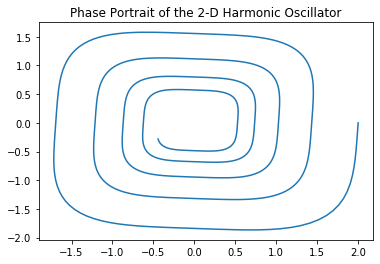

In [3]:
# Phase plane plot
plt.plot(cubic_data[0,:,0], cubic_data[0,:,1])
plt.title('Phase Portrait of the 2-D Harmonic Oscillator')

Now that we have simulated a dataset, let's create a suitable training data and augment it for learning.

# 2. LmmNet

Next, we train the LmmNet on the tensor data.

In [4]:
# we specify a LMM scheme and number of steps
dt = time_points[1] - time_points[0]
M = 1
scheme = 'AM'
model = lmmNet(dt, cubic_data, M, scheme, hidden_units=256)

N_Iter = 10000
model.train(N_Iter, debug=False)

In [5]:
x0 = cubic_data[0,0,:] # initial conditions
predicted_traj = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), x0, time_points)

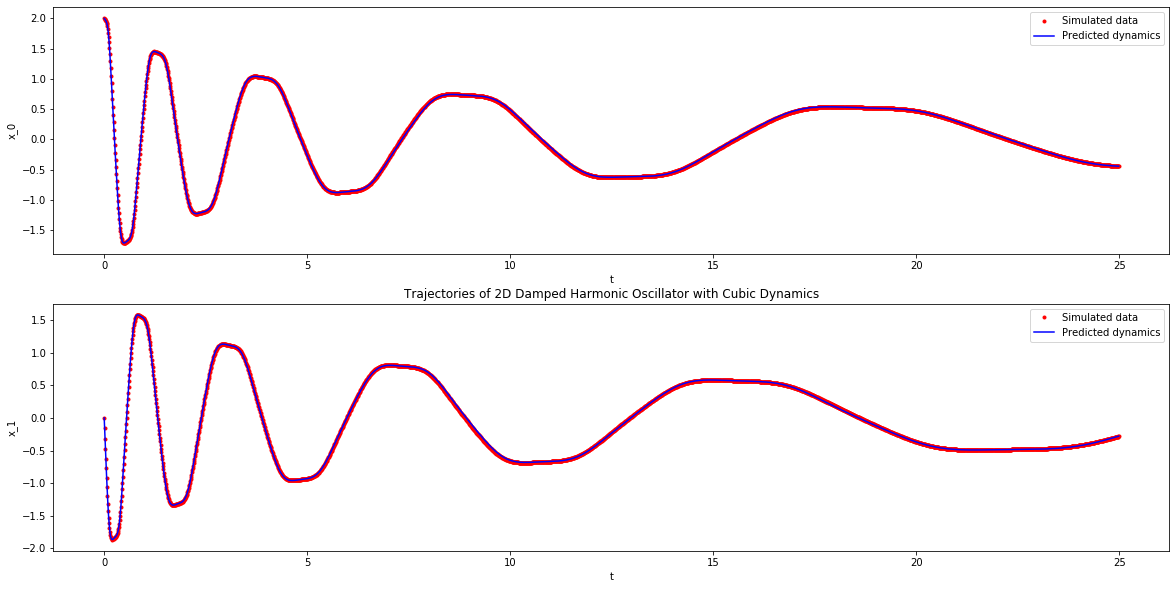

In [6]:
# plot the time-course of the predicted trajectory

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, cubic_data[0,:, species], 'r.', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'b-', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Damped Harmonic Oscillator with Cubic Dynamics')
plt.show()

Text(0.5, 1.0, 'Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

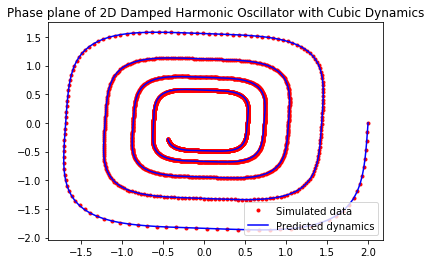

In [7]:
# Phase plane

plt.plot(cubic_data[0,:,0], cubic_data[0,:,1], 'r.', label='Simulated data')
plt.legend()
plt.plot(predicted_traj[:,0], predicted_traj[:,1], 'b-', label='Predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

# 3. One-step machine learning method

Workflow:
* create and augment training data
* fit model with pairs of derivatives and time-series measurements as features
* make predictions and simulations by numerical integration of the learned model

In [8]:
# function to prepare data for training one-step method
from utils import *

feature_list = [] # here we do not have external time-series or control variables
target_list = ['x_component', 'y_component']

# now generate and augment the training dataset
df = create_data(cubic_data, time_points, cols=target_list)

Shape of the dataframe is: (2500, 3)


In [9]:
# create training data with different augmentation

df_train = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=2500)
df_train2 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=5000)
df_train3 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=30000)

x_component


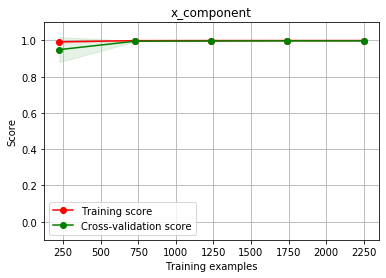

Target: x_component, CV Pearson R2 coefficient: 0.999745
y_component


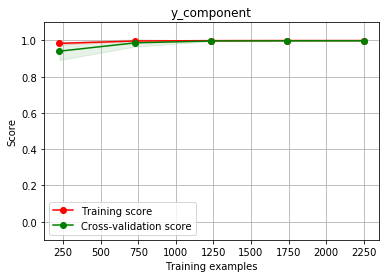

Target: y_component, CV Pearson R2 coefficient: 0.999766
Average training score: 0.9997553044222882
x_component RMSE: -0.0003721345931082355 standard deviation: 0.028445336564889


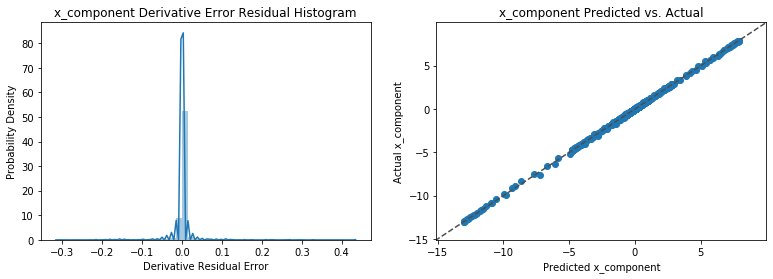

y_component RMSE: -0.0006238709674212885 standard deviation: 0.02764699101481474


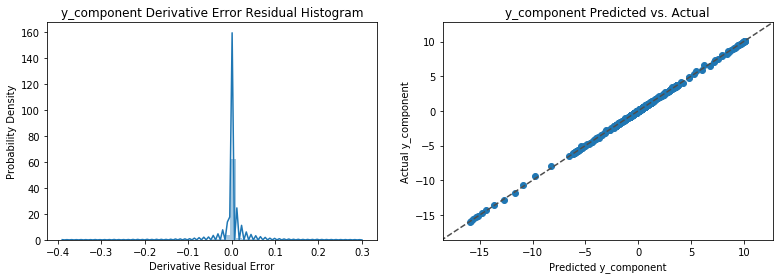

Total Derivative Mean Error: 0.04534867117540251 Error Standard Deviation: 0.07530690627282044


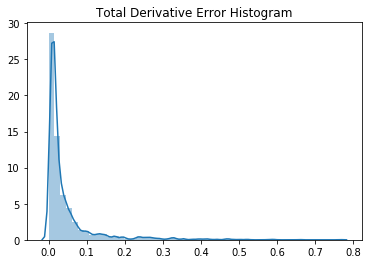

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.994420,-0.158741
0.02,1.988081,-0.316077
0.03,1.980512,-0.471564
0.04,1.973584,-0.624390
...,...,...
24.95,0.421612,0.127094
24.96,0.421434,0.125402
24.97,0.421256,0.123709


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 5.077358019738761 RMSE percentage: 184.6098458022083
ML Fit: y_component 5.154433514485747 RMSE percentage: 180.54646495447415
ML model aggregate error
Average RMSE: 5.115895767112255
Total percentage error: 182.57815537834122


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


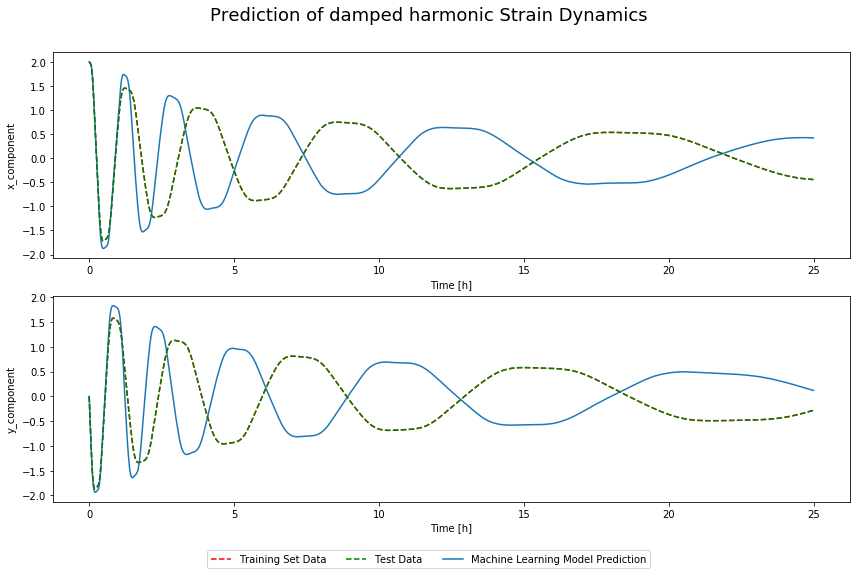

x_component


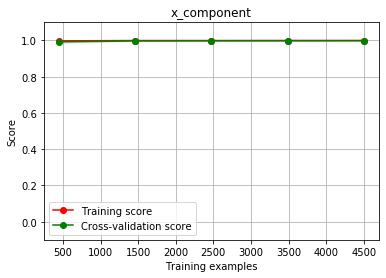

Target: x_component, CV Pearson R2 coefficient: 0.999832
y_component


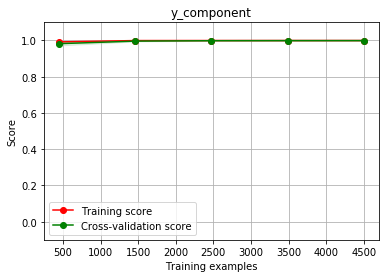

Target: y_component, CV Pearson R2 coefficient: 0.999865
Average training score: 0.9998485601810643
x_component RMSE: 0.00011913490639046048 standard deviation: 0.023048154000265993


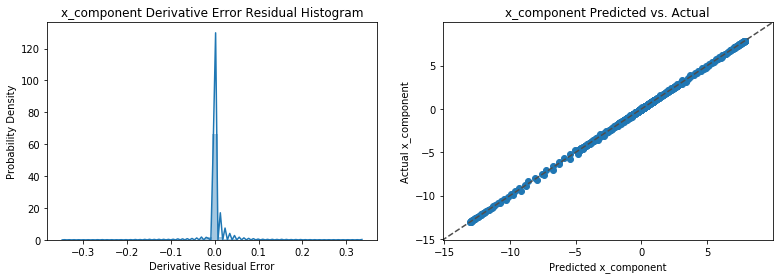

y_component RMSE: -0.00021544128674883277 standard deviation: 0.020943894867557024


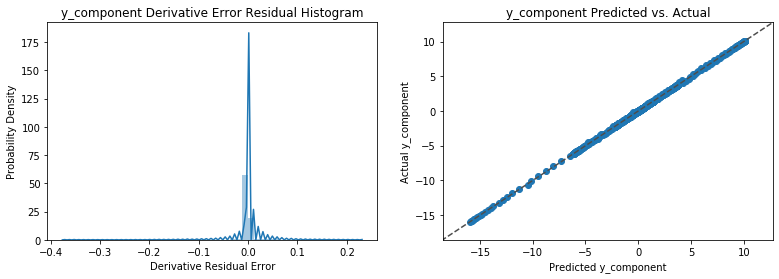

Total Derivative Mean Error: 0.033817263095427395 Error Standard Deviation: 0.0642432963247337


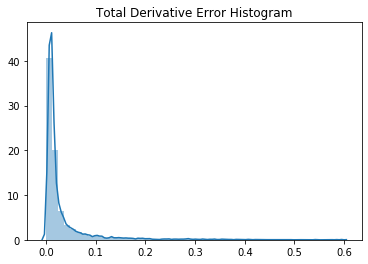

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.992343,-0.158542
0.02,1.984406,-0.315585
0.03,1.976840,-0.470971
0.04,1.967901,-0.623714
...,...,...
24.95,0.397255,0.181775
24.96,0.397133,0.180351
24.97,0.397012,0.178927


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 4.920903404022082 RMSE percentage: 177.02300576484663


./source/predict_onestep.py:222: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: y_component 5.009539693285209 RMSE percentage: 180.52542896494606
ML model aggregate error
Average RMSE: 4.965221548653645
Total percentage error: 178.77421736489634


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


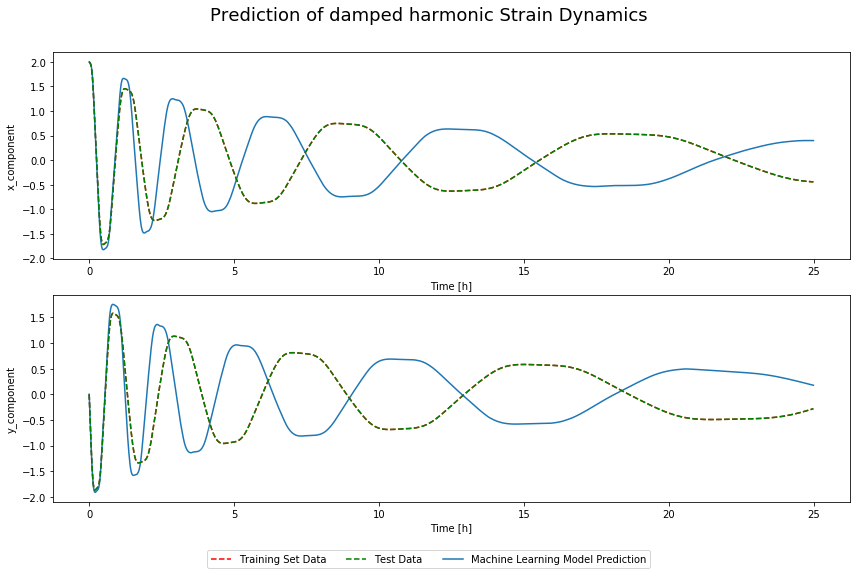

x_component


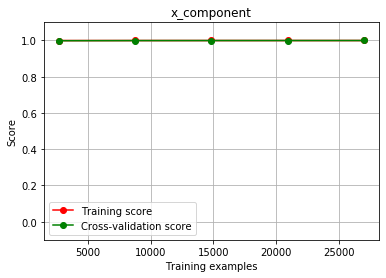

Target: x_component, CV Pearson R2 coefficient: 0.999989
y_component


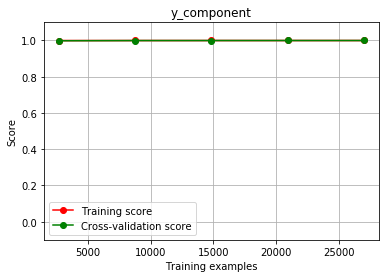

Target: y_component, CV Pearson R2 coefficient: 0.999991
Average training score: 0.9999899410055763
x_component RMSE: 3.814954463634618e-05 standard deviation: 0.005942583562520581


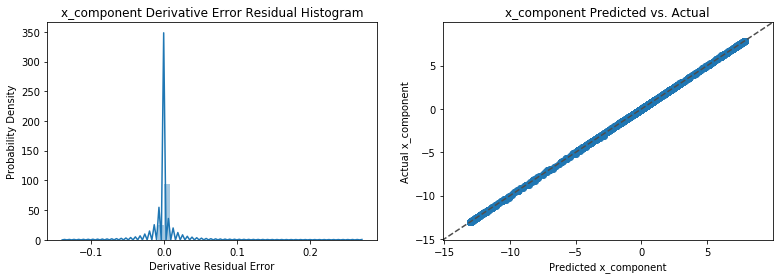

y_component RMSE: -6.801704949459894e-05 standard deviation: 0.005378065919165218


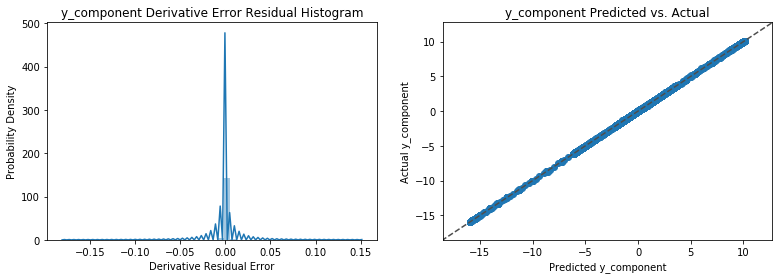

Total Derivative Mean Error: 0.014427311040998425 Error Standard Deviation: 0.025647343124288315


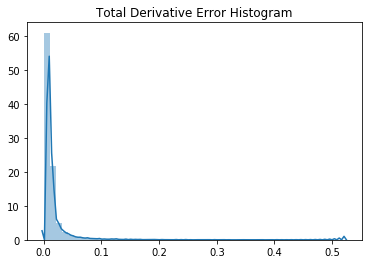

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.992026,-0.159091
0.02,1.983859,-0.316217
0.03,1.974804,-0.471326
0.04,1.963742,-0.623923
...,...,...
24.95,-0.441751,-0.291922
24.96,-0.442148,-0.290176
24.97,-0.442534,-0.288425


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 0.01675153723015805 RMSE percentage: 14.08757882032072
ML Fit: y_component 0.016168228569787016 RMSE percentage: 13.441479882070418
ML model aggregate error
Average RMSE: 0.016459882899972533
Total percentage error: 13.76452935119557


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


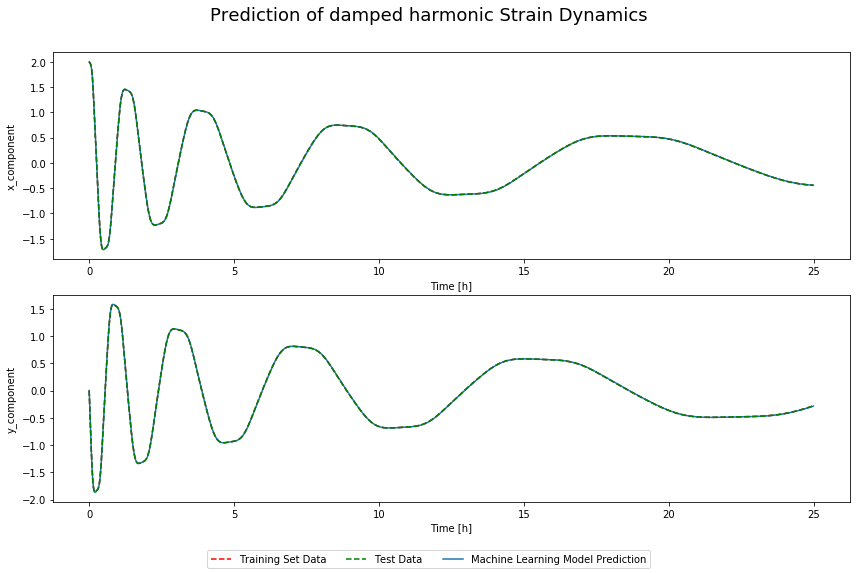

In [11]:
# train model and make predictions

tp1, pred1 = end_to_end_training(df, df_train, df, feature_list, target_list, (2,1))
tp2, pred2 = end_to_end_training(df, df_train2, df, feature_list, target_list, (2,1))
tp3, pred3 = end_to_end_training(df, df_train3, df, feature_list, target_list, (2,1))

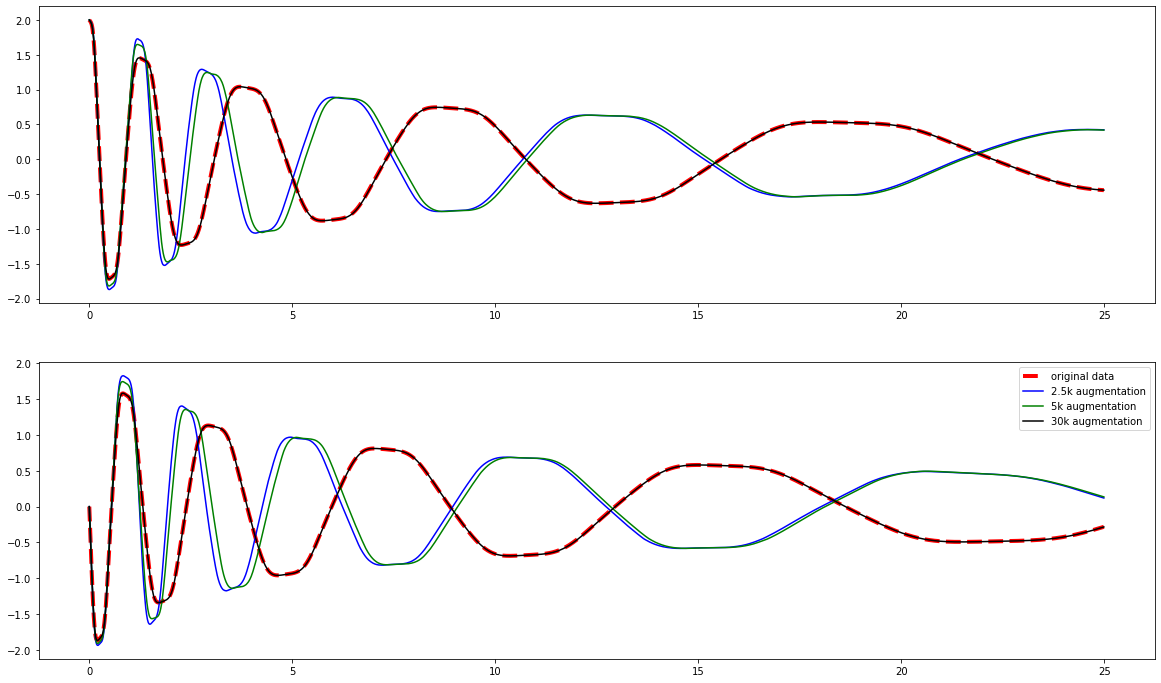

In [13]:
# plot the predictions in one figure

# make sure the augmented data corresponds to the original data
plt.figure(figsize = (20, 12))
for species in range(2):
    plt.subplot(2, 1, species + 1)
    plt.plot(time_points, df.iloc[:,species], 'r--', linewidth=4, label='original data')
    plt.plot(tp1, pred1.iloc[:,species], 'b-', label='2.5k augmentation')
    plt.plot(tp2, pred2.iloc[:,species], 'g-', label='5k augmentation')
    plt.plot(tp3, pred3.iloc[:,species], 'k-', label='30k augmentation')
    
plt.legend()

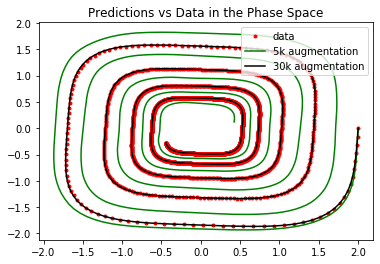

In [14]:
# Phase plane plot
plt.plot(cubic_data[0,:,0], cubic_data[0,:,1], 'r.', label='data')
plt.plot(pred1.iloc[:,0], pred1.iloc[:,1], 'g-', label='5k augmentation')
plt.plot(pred3.iloc[:,0], pred3.iloc[:,1], 'k-', label='30k augmentation')
plt.title('Predictions vs Data in the Phase Space')
plt.legend()

# 4. Prediction on unseen initial values

Let's evaluate the model on unseen initial conditions. First for one-step learning and next for LmmNet.

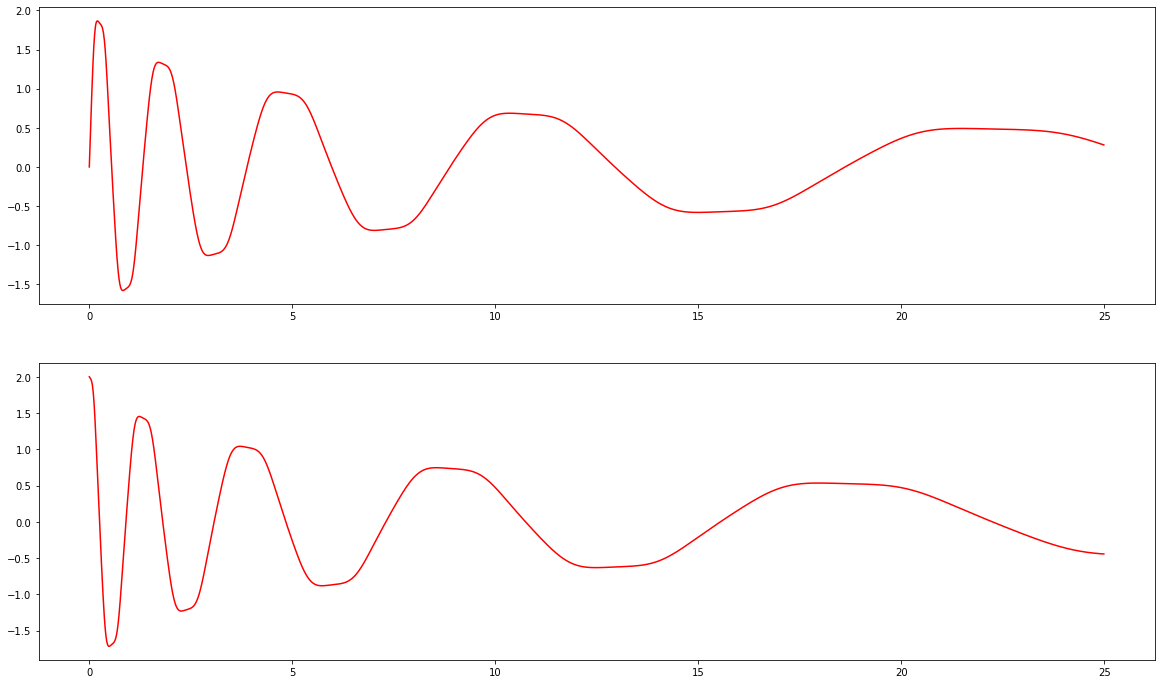

In [7]:
time_points, data2 = harmonic.simulate_custom(xinit=0, yinit=2)

plt.figure(figsize = (20, 12))
for species in range(2):
    plt.subplot(2, 1, species + 1)
    plt.plot(time_points, data2[0,:,species], 'r-')

Shape of the dataframe is: (2500, 3)
x_component


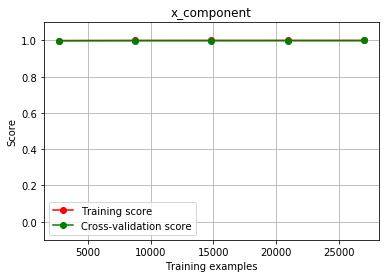

Target: x_component, CV Pearson R2 coefficient: 0.999989
y_component


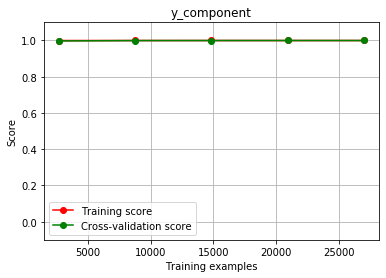

Target: y_component, CV Pearson R2 coefficient: 0.999990
Average training score: 0.9999895154892935
x_component RMSE: 5.954742966682015e-05 standard deviation: 0.005981261500062701


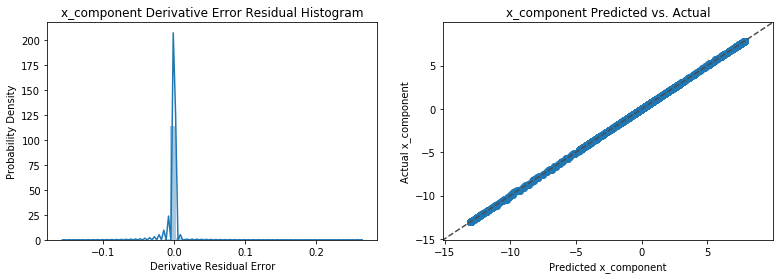

y_component RMSE: -8.42810284074016e-05 standard deviation: 0.005585067908684906


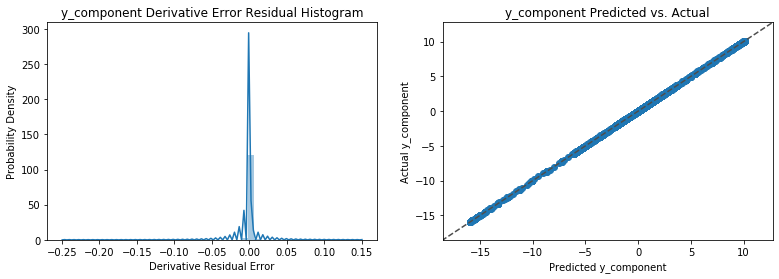

Total Derivative Mean Error: 0.014340284413504155 Error Standard Deviation: 0.025319432800254376


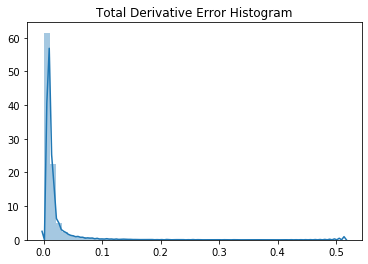

Real data:


,x_component,y_component
Strain,,
1,0.000000,2.000000
1,0.159044,1.992028
1,0.316164,1.983873
1,0.471225,1.974847
1,0.623866,1.963856
...,...,...
1,0.288236,-0.441769
1,0.286486,-0.442157
1,0.284731,-0.442536


Predicted data:


,x_component,y_component
Time,,
0.00,0.000000,2.000000
0.01,0.078462,1.996573
0.02,0.156925,1.993142
0.03,0.235387,1.989691
0.04,0.313849,1.985992
...,...,...
24.95,0.379564,0.037668
24.96,0.379342,0.036339
24.97,0.379119,0.035018


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 1.9898102301285008 RMSE percentage: 173.421610831615


./source/predict_onestep.py:222: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: y_component 2.089682114644841 RMSE percentage: 286.7584374179626
ML model aggregate error
Average RMSE: 2.0397461723866708
Total percentage error: 230.09002412478884


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


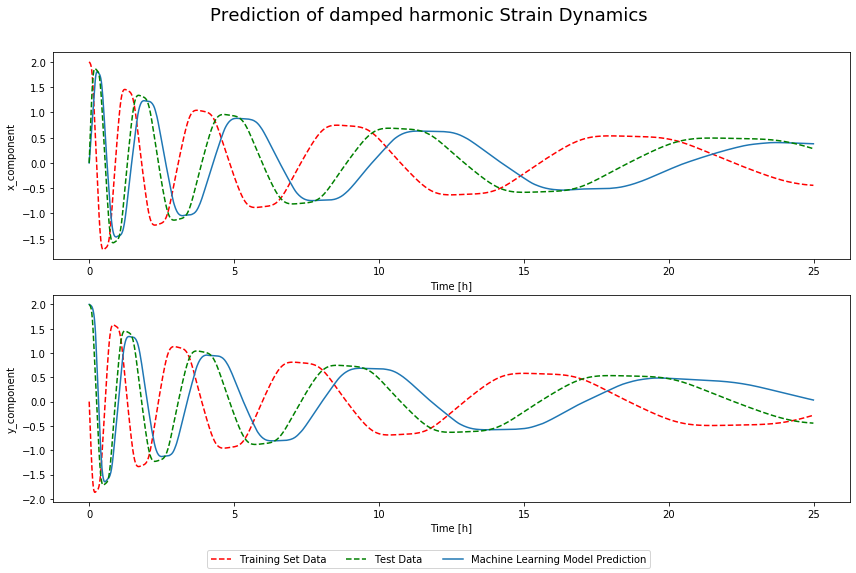

In [18]:
# one-step learning

df2 = create_data(data2,time_points, cols=target_list, num=1)
tp, pred = end_to_end_training(df2, df_train3, df, feature_list, target_list, (2,1))

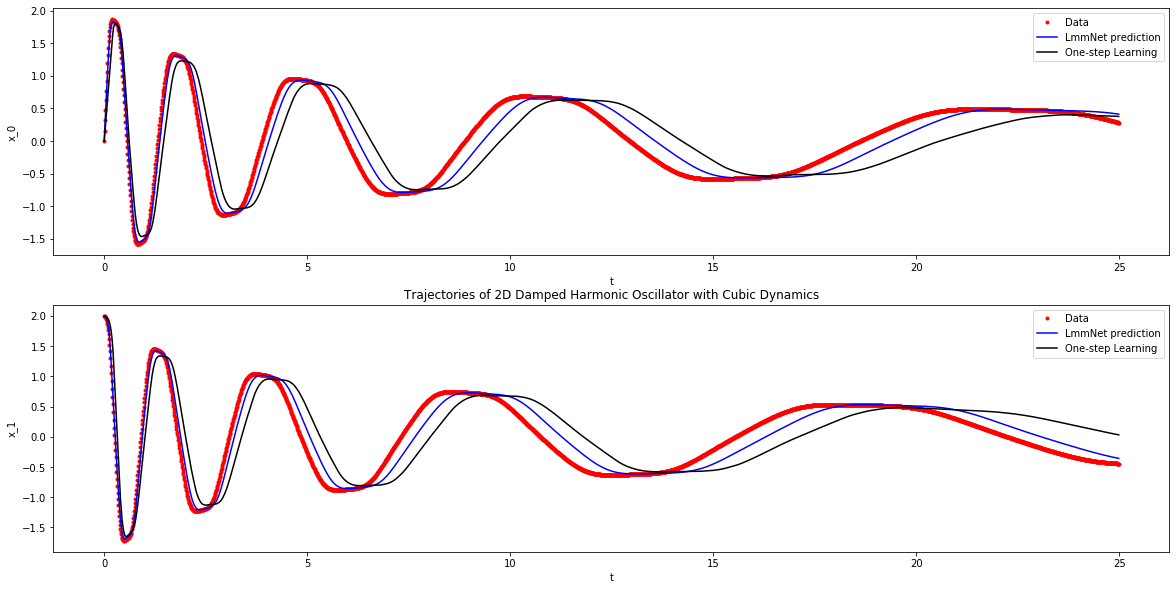

In [19]:
pred_lnet = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), data2[0,0,:], time_points)

# plot the time-course of the predicted trajectory
plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, data2[0,:, species], 'r.', label='Data')
    plt.plot(time_points, pred_lnet[:,species], 'b-', label='LmmNet prediction')
    plt.plot(tp, pred.iloc[:,species], 'k-', label='One-step Learning')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Damped Harmonic Oscillator with Cubic Dynamics')
plt.show()

# LMMNet for prediction --> check if you're using the same time step.

Text(0.5, 1.0, 'Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

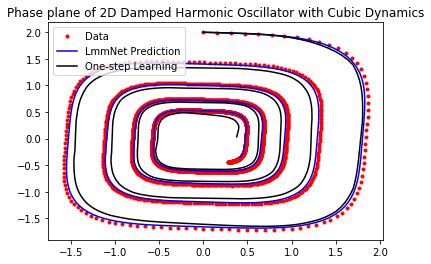

In [20]:
# Phase plane

plt.plot(data2[0,:,0], data2[0,:,1], 'r.', label='Data')
plt.plot(pred_lnet[:,0], pred_lnet[:,1], 'b-', label='LmmNet Prediction')
plt.plot(pred.iloc[:,0], pred.iloc[:,1], 'k-', label='One-step Learning')
plt.legend()
plt.title('Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

Note that in the SINDy paper, the evaluation is only done on the training data as below.

<img src=image/cubic-sindy.png alt="drawing" align ="left" width="300"/>  

**SINDy results (Brunton et al., 2016)**. 